# ***Import Libraries and Load data***

In [1]:
import dask.dataframe as dd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np

# --------------------------- Load data -----------------------
df = dd.read_parquet(
    "hf://datasets/blackhole-boys/recomendation-system-dataset-v1/data/train-*.parquet").head(40000)

print(df.head())
print("Dataset size:", len(df))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


                                               image  label
0  {'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...      0
1  {'bytes': b'RIFF\xf8H\x00\x00WEBPVP8 \xecH\x00...      0
2  {'bytes': b'RIFF\x96\x91\x00\x00WEBPVP8 \x8a\x...      0
3  {'bytes': b'RIFF\xa4\x9d\x00\x00WEBPVP8 \x98\x...      0
4  {'bytes': b'RIFFT\xa0\x00\x00WEBPVP8 H\xa0\x00...      0
Dataset size: 2880


/usr/local/lib/python3.12/dist-packages/dask/dataframe/core.py:382: UserWarning: Insufficient elements for `head`. 40000 elements requested, only 2880 elements available. Try passing larger `npartitions` to `head`.
  warnings.warn(


# **Image Dataset**

In [2]:
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_bytes = row["image"]["bytes"]
        label = row["label"]

        img = Image.open(io.BytesIO(img_bytes)).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, torch.tensor(label, dtype=torch.long), idx


***Convolutional Neural Network ( CNN ) Classifier***

In [3]:
class CNN_Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4   = nn.BatchNorm2d(256)

        self.gap   = nn.AdaptiveAvgPool2d((4, 4))

        self.fc1   = nn.Linear(256 * 4 * 4, 512)
        self.drop  = nn.Dropout(0.5)
        self.fc2   = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))

        x = self.gap(x)           # [B, 256, 4, 4]
        x = x.view(x.size(0), -1) # Flatten
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        return x

***Data Preparation***

In [4]:
# ---------------------- Data settings -------------------------
IMG_SIZE = 128
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

dataset = ImageDataset(df, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

***Training Setup***

In [5]:
# ----------------------- Training setup ------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

num_classes = len(df["label"].unique())
model = CNN_Classifier(num_classes=num_classes).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for X_batch, y_batch, _ in tqdm(loader, desc="Training", leave=False):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (preds.argmax(1) == y_batch).sum().item()
        total += y_batch.size(0)

    return total_loss/len(loader), correct/total


Using device: cuda


***Evaluation Function***

In [6]:
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for X_batch, y_batch, _ in tqdm(loader, desc="Evaluating", leave=False):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            loss = criterion(preds, y_batch)
            total_loss += loss.item()
            correct += (preds.argmax(1) == y_batch).sum().item()
            total += y_batch.size(0)
    return total_loss/len(loader), correct/total


***Training with Loop & Early stoping***

In [8]:
import io
from torch.optim.lr_scheduler import ReduceLROnPlateau

EPOCHS = 30
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0
# Learning Rate
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)


for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer)
    val_loss, val_acc = evaluate(model, val_loader)
    print(f"Epoch {epoch}: Train Loss={tr_loss:.4f}, Acc={tr_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping after {epoch} epochs as validation loss did not improve for {patience} epochs.")
            break

Training:   0%|          | 0/72 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 1: Train Loss=1.8592, Acc=0.5143 | Val Loss=1.9423, Acc=0.4236


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 2: Train Loss=1.3223, Acc=0.6228 | Val Loss=1.1932, Acc=0.6667


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 3: Train Loss=1.1377, Acc=0.6680 | Val Loss=1.1449, Acc=0.6858


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 4: Train Loss=1.0246, Acc=0.6905 | Val Loss=1.2963, Acc=0.6823


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 5: Train Loss=0.9497, Acc=0.7183 | Val Loss=0.9663, Acc=0.7083


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 6: Train Loss=0.8251, Acc=0.7461 | Val Loss=0.8505, Acc=0.7604


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 7: Train Loss=0.7667, Acc=0.7674 | Val Loss=0.8195, Acc=0.7708


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 8: Train Loss=0.6704, Acc=0.7999 | Val Loss=0.8778, Acc=0.7604


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 9: Train Loss=0.6650, Acc=0.7960 | Val Loss=0.7433, Acc=0.8021


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 10: Train Loss=0.6246, Acc=0.8090 | Val Loss=0.7665, Acc=0.7899


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 11: Train Loss=0.5613, Acc=0.8173 | Val Loss=0.7878, Acc=0.7569


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 12: Train Loss=0.4589, Acc=0.8542 | Val Loss=0.8260, Acc=0.7847


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 13: Train Loss=0.4625, Acc=0.8533 | Val Loss=0.6399, Acc=0.8316


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 14: Train Loss=0.4438, Acc=0.8520 | Val Loss=1.1599, Acc=0.6233


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 15: Train Loss=0.4243, Acc=0.8598 | Val Loss=1.1660, Acc=0.6181


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 16: Train Loss=0.4307, Acc=0.8585 | Val Loss=0.5584, Acc=0.8594


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 17: Train Loss=0.3587, Acc=0.8832 | Val Loss=0.7467, Acc=0.8160


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 18: Train Loss=0.3319, Acc=0.8984 | Val Loss=0.5926, Acc=0.8420


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 19: Train Loss=0.3132, Acc=0.9002 | Val Loss=0.5826, Acc=0.8524


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 20: Train Loss=0.2862, Acc=0.9128 | Val Loss=0.6413, Acc=0.8438


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 21: Train Loss=0.2155, Acc=0.9323 | Val Loss=0.5005, Acc=0.8750


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 22: Train Loss=0.1797, Acc=0.9410 | Val Loss=0.4873, Acc=0.8715


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 23: Train Loss=0.1685, Acc=0.9414 | Val Loss=0.4991, Acc=0.8802


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 24: Train Loss=0.1609, Acc=0.9457 | Val Loss=0.4989, Acc=0.8819


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 25: Train Loss=0.1399, Acc=0.9531 | Val Loss=0.4948, Acc=0.8802


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 26: Train Loss=0.1397, Acc=0.9592 | Val Loss=0.4963, Acc=0.8785


Training:   0%|          | 0/72 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/18 [00:00<?, ?it/s]

Epoch 27: Train Loss=0.1317, Acc=0.9579 | Val Loss=0.4927, Acc=0.8854
Early stopping after 27 epochs as validation loss did not improve for 5 epochs.


# **Feature Extraction using CNN Embeddings**

In [9]:
from sklearn.metrics.pairwise import cosine_similarity

def get_embeddings(model, loader):
    model.eval()
    features = []
    labels = []
    indices = []
    with torch.no_grad():
        for X_batch, y_batch, idx in tqdm(loader, desc="Extracting features"):
            X_batch = X_batch.to(device)
            feats = model.forward_features(X_batch)  # هنا هنعدل CNN شوية
            features.append(feats.cpu().numpy())
            labels.extend(y_batch.numpy())
            indices.extend(idx.numpy())
    features = np.vstack(features)
    return features, np.array(labels), np.array(indices)

class CNN_Classifier(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn2   = nn.BatchNorm2d(64)
        self.pool  = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn3   = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.bn4   = nn.BatchNorm2d(256)

        self.gap   = nn.AdaptiveAvgPool2d((4, 4))
        self.fc1   = nn.Linear(256 * 4 * 4, 512)
        self.drop  = nn.Dropout(0.5)
        self.fc2   = nn.Linear(512, num_classes)

    def forward_features(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.gap(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.drop(x)
        x = self.fc2(x)
        return x
new_model = CNN_Classifier(num_classes=num_classes).to(device)
new_model.load_state_dict(model.state_dict())  # model القديم
model = new_model

# **Image Recommendation using Embeddings & Cosine Similarity**

Extracting features:   0%|          | 0/18 [00:00<?, ?it/s]

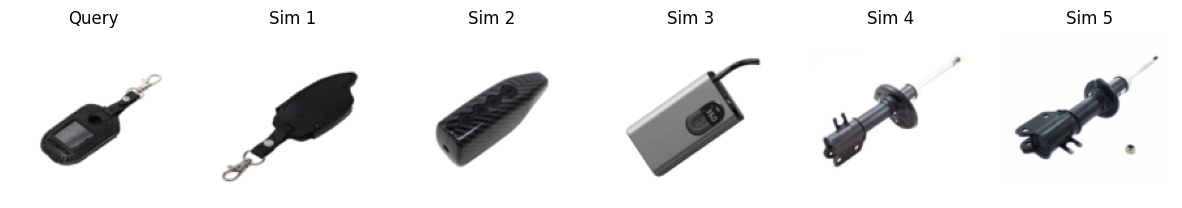

In [10]:
# ---------------- Recommendation -----------------
embeddings, labels, indices = get_embeddings(model, val_loader)

def recommend(query_idx, k=5):
    query_emb = embeddings[query_idx].reshape(1, -1)
    sims = cosine_similarity(query_emb, embeddings)[0]
    topk = sims.argsort()[-k-1:][::-1]
    return topk[1:]

q_idx = 10
neighbors = recommend(q_idx, k=5)

# Visualization
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
query_img, _, _ = dataset[indices[q_idx]]
axes[0].imshow(query_img.permute(1, 2, 0))
axes[0].set_title("Query")
axes[0].axis("off")

for i, n_idx in enumerate(neighbors):
    img, _, _ = dataset[indices[n_idx]]
    axes[i+1].imshow(img.permute(1, 2, 0))
    axes[i+1].set_title(f"Sim {i+1}")
    axes[i+1].axis("off")

plt.show()

# **confusion matrix & Evaluate model by Visualization**

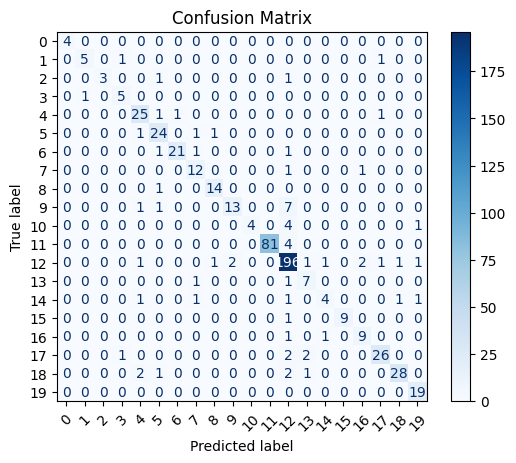

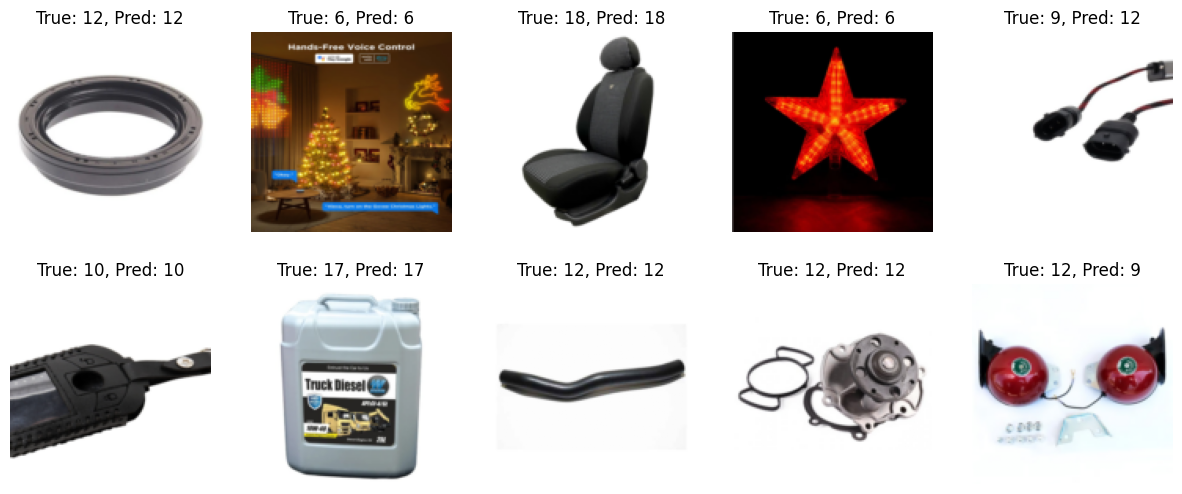

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ========= 1. Confusion Matrix =========
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for X_batch, y_batch, _ in val_loader:
        X_batch = X_batch.to(device)
        preds = model(X_batch).argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(y_batch.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


# ========= 2. Sample Predictions =========
fig, axes = plt.subplots(2, 5, figsize=(15,6))
model.eval()
with torch.no_grad():
    for i, ax in enumerate(axes.flatten()):
        img, label, _ = dataset[indices[i]]
        pred = model(img.unsqueeze(0).to(device)).argmax(1).item()
        ax.imshow(img.permute(1,2,0))
        ax.set_title(f"True: {label}, Pred: {pred}")
        ax.axis("off")

plt.show()


# **Recommendation**

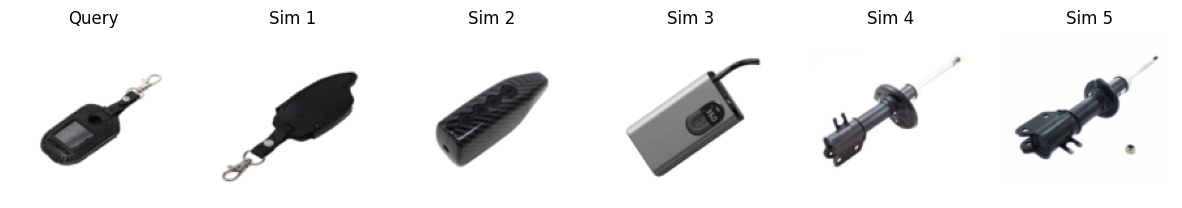

In [35]:
fig, axes = plt.subplots(1, 6, figsize=(15, 3))
query_img, _, _ = dataset[indices[q_idx]]
axes[0].imshow(query_img.permute(1, 2, 0))
axes[0].set_title("Query")
axes[0].axis("off")

for i, n_idx in enumerate(neighbors):
    img, _, _ = dataset[indices[n_idx]]
    axes[i+1].imshow(img.permute(1, 2, 0))
    axes[i+1].set_title(f"Sim {i+1}")
    axes[i+1].axis("off")

plt.show()
